## Multilayer Perceptrons
- 이번 실습에서는 multilayer perceptron model을 이용하여 classification model을 학습시켜봅니다.
- hidden layer의 개수, hidden unit의 개수, activation function의 종류를 바꾸는 방법을 익힙니다.
- regularization을 위한 방법(weight decay, dropout 등)을 적용하는 방법을 익힙니다.
- training set과 validation set의 accuracy가 epoch에 따라 어떻게 변하는지 관찰하여 모델을 학습시켜 봅니다.

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import os

from torch import nn

### ECG데이터 가져오기

In [2]:
dpath = 'training2017'
d = pd.read_csv(os.path.join(dpath,'REFERENCE.csv'),header=None)
d[:3]

,0,1
0,A00001,N
1,A00002,N
2,A00003,N


In [3]:
Nlist = d[d[1]=='N']
Alist = d[d[1]=='A']

In [4]:
Nvd = 50
Nlist_vd = Nlist[-Nvd:]
Alist_vd = Alist[-Nvd:]
Nlist = Nlist[:-Nvd]
Alist = Alist[:-Nvd]

In [5]:
def data_iter(batch_size, dpath, Nlist, Alist, L):
    num_examplesN = len(Nlist)
    num_examplesA = len(Alist)
    indicesN = list(range(num_examplesN))
    indicesA = list(range(num_examplesA))
    # The examples are read at random, in no particular order
    random.shuffle(indicesN)
    batch_size2 = int(batch_size/2)
    for i in range(0, num_examplesN, batch_size):
        batch_indicesN = indicesN[i:min(i+batch_size2, num_examplesN)]
        random.shuffle(indicesA)
        features = torch.zeros((batch_size,L))
        labels = torch.zeros((batch_size,))
        for bi in range(0, len(batch_indicesN)):
            sign = sio.loadmat(os.path.join(dpath,Nlist.iloc[batch_indicesN[bi],0]+'.mat'))  
            siga = sio.loadmat(os.path.join(dpath,Alist.iloc[indicesA[bi],0]+'.mat'))
            sign = sign['val']
            siga = siga['val']            
            r1 = random.randint(0,len(sign[0,:])-L)
            r2 = random.randint(0,len(siga[0,:])-L)
#            r1 = 800
#            r2 = 800
            features[2*bi,:] = torch.tensor(sign[0,r1:r1+L])
            features[2*bi+1,:] = torch.tensor(siga[0,r2:r2+L])
            labels[2*bi] = 0
            labels[2*bi+1] = 1
            
        yield 0.001*features, labels

torch.Size([16, 2048])
torch.Size([16])


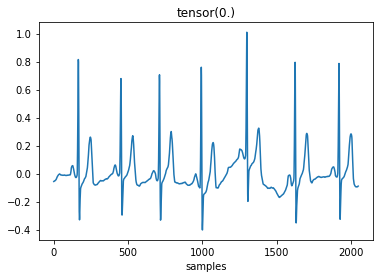

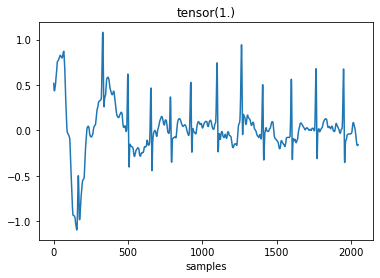

In [7]:
L = 2048
i = 0
for X_tr, y_tr in data_iter(16,dpath,Nlist,Alist,L):
    print(X_tr.shape)
    print(y_tr.shape)
    i=i+1
    for n in range(2):
        plt.plot(X_tr[n])
        plt.title(y_tr[n])
        plt.xlabel('samples')
        plt.show()
    break

### Hyperparameter설정

In [8]:
L = 1024
batch_size = 64
lr = 0.01
num_epochs = 1000

### Model, loss function, algorithm

In [9]:
net = nn.Sequential(nn.Linear(L, L),nn.Dropout(p=0.5),nn.ReLU(),nn.Linear(L,2))   
loss = nn.CrossEntropyLoss(reduction='mean')
alg = torch.optim.SGD(net.parameters(),lr, weight_decay=0.01)

### Model 학습

epoch #0,train loss: 0.693629832207402
accuracy of train set: 50.17800632911393 %
accuracy of valid set: 50.0 %
epoch #10,train loss: 0.6896814273882516
accuracy of train set: 53.401898734177216 %
accuracy of valid set: 44.0 %
epoch #20,train loss: 0.6858151109912728
accuracy of train set: 57.14003164556962 %
accuracy of valid set: 56.0 %
epoch #30,train loss: 0.6846662110920194
accuracy of train set: 58.80142405063291 %
accuracy of valid set: 50.0 %
epoch #40,train loss: 0.6804078017609029
accuracy of train set: 60.561708860759495 %
accuracy of valid set: 58.0 %
epoch #50,train loss: 0.6785774713830103
accuracy of train set: 61.11550632911393 %
accuracy of valid set: 56.0 %
epoch #60,train loss: 0.6760210447673556
accuracy of train set: 62.91534810126582 %
accuracy of valid set: 70.0 %
epoch #70,train loss: 0.6739605287962322
accuracy of train set: 62.045094936708864 %
accuracy of valid set: 56.0 %
epoch #80,train loss: 0.672639436359647
accuracy of train set: 62.124208860759495 %
acc

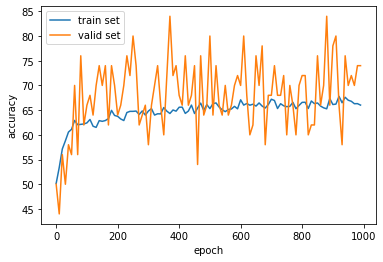

In [10]:
epoch_tr_accuracy = []
epoch_vd_accuracy = []
eval_interval = 10
for epoch in range(num_epochs):
    l_train = []
    i = 0
    Ncorrect=0
    N=0
    for X_tr, y_tr in data_iter(batch_size,dpath,Nlist,Alist,L):
        y_tr_pred = net(X_tr)
        l = loss(y_tr_pred, y_tr.type(torch.LongTensor))
        l_train.append(l.sum().detach().numpy())
        l.backward()
        alg.step()
        alg.zero_grad()
        Ncorrect += torch.sum(y_tr==torch.argmax(y_tr_pred.softmax(1),dim=1)).numpy()
        N += len(X_tr)
        i=i+1
    if epoch%eval_interval==0:
        print(f'epoch #{epoch},train loss: {np.sum(l_train)/i}')
        tr_accuracy = 100*Ncorrect/(N)
        print(f'accuracy of train set: {tr_accuracy} %')

#        print(f'weights: {net[0].weight[0][:4]}, ...')
        for X_vd, y_vd in data_iter(Nvd,dpath,Nlist_vd,Alist_vd,L):
            y_vd_pred = net(X_vd)
            vd_accuracy = 100*torch.sum(y_vd==torch.argmax(y_vd_pred.softmax(1),dim=1))/Nvd 
            print(f'accuracy of valid set: {vd_accuracy} %')
        epoch_tr_accuracy.append(tr_accuracy)
        epoch_vd_accuracy.append(vd_accuracy)

x = np.arange(0,num_epochs,eval_interval)
plt.plot(x,epoch_tr_accuracy)
plt.plot(x,epoch_vd_accuracy)
plt.legend(['train set','valid set'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()